#  Retrieval Augmented Generation (RAG) App



focus on **adding logic for incorporating historical messages.** This involves the management of a

two approaches:

1. [Chains](/docs/tutorials/qa_chat_history/#chains), in which we execute at most one retrieval step;
2. [Agents](/docs/tutorials/qa_chat_history/#agents), in which we give an LLM discretion to execute multiple retrieval steps.


## Setup

### Components

We will need to select three components from LangChain's suite of integrations.

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [11]:
%pip install python-dotenv

In [12]:
import os
import getpass
from dotenv import load_dotenv
import openai

# Load environment variables from .env file if it exists
load_dotenv()

# Try to get the API key from environment
API_key = os.getenv("OPENAI_API_KEY")
# os.environ[OPENAI_API_key] = "my_value"
# If not found, prompt user securely
if not API_key:
    print("OpenAI API key not found in environment. Please enter it manually.")
    API_key = getpass.getpass("Enter your OpenAI API key: ")

os.environ["OPENAI_API_KEY"] = API_key

# Final check: raise error if still not set
if not API_key:
    raise ValueError("OpenAI API key not provided. Set it in .env or enter it manually.")


OpenAI API key not found in environment. Please enter it manually.
Enter your OpenAI API key: ··········


In [6]:
# | output: false
# | echo: false

!pip install langchain_openai
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini",
                 api_key = API_key

                 )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.60
    Uninstalling langchain-core-0.3.60:
      Successfully uninstalled langchain-core-0.3.60


import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [13]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [14]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### Dependencies

In addition, we'll use the following packages:

In [15]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

### LangSmith (optional)

LangChain will contain multiple steps with multiple invocations of LLM calls.  [LangSmith](https://smith.langchain.com) helps inspecting the llm and agent calls

```python
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

In [ ]:
os.environ["LANGSMITH_TRACING"] = "true"


## Chains {#chains}

Let's first revisit the vector store we built in [Part 1](/docs/tutorials/rag), which indexes an [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng.

In [8]:
%pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00


In [16]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# PDFS (optional)

In [ ]:
file_path = "test.pdf" #set

In [9]:
from pickle import load
from langchain_community.document_loaders import PyPDFLoader
#load into pages variable
async def load_pdf(file_path):
    loader = PyPDFLoader(file_path)
    pages = []
    # for page in loader.load_and_split():
    #     pages.append(page)
    async for page in loader.alazy_load():
          pages.append(page)
    return pages
#cite sources
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

pages = load_pdf(file_path)

vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

NameError: name 'file_path' is not defined

#IMAGES(optional)

In [ ]:
file_path = "test.pdf" #set

In [ ]:
%pip install langchain_unstructured
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

# **Vector Database**

In [18]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)


1. User input as a `HumanMessage`;
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage`.

This model for state is so versatile that LangGraph offers a built-in version for convenience:

In [19]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)



> Human: "What is Task Decomposition?"
>
> AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."
>
> Human: "What are common ways of doing it?"


In [20]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.


In [21]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

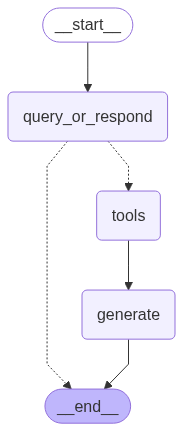

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


# **Let's test our application.**
Note that it responds appropriately to messages that do not require an additional retrieval step:

In [24]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


And when executing a search, we can stream the steps to observe the query generation, retrieval, and answer generation:

In [25]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_qzePJ3ObbYh8zU5iwGNargxJ)
 Call ID: call_qzePJ3ObbYh8zU5iwGNargxJ
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights int

Check out the LangSmith trace [here](https://smith.langchain.com/public/70110399-01d3-4b4b-9139-cbcd4edf9d6d/r).

### Stateful management of chat history


In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

We can now invoke similar to before:

In [27]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config, # important for memory
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_AhebAsMnQ9SNYlwiq9CMiMLY)
 Call ID: call_AhebAsMnQ9SNYlwiq9CMiMLY
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights int

In [28]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_EzE3HmRpc7nKw8tWOMtKz51w)
 Call ID: call_EzE3HmRpc7nKw8tWOMtKz51w
  Args:
    query: common methods for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple

Note that the query generated by the model in the second question incorporates the conversational context.

The [LangSmith](https://smith.langchain.com/public/28e6179f-fc56-45e1-9028-447d76352c14/r) trace is particularly informative here, as we can see exactly what messages are visible to our chat model at each step.

## Agents {#agents}


Below we assemble a minimal RAG agent. Using LangGraph's [pre-built ReAct agent constructor](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent), we can do this in one line.


 LangGraph's [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) tutorial for more advanced formulations.

:::

In [29]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

Let's inspect the graph:

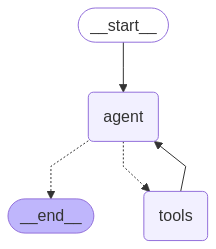

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

The key difference from our earlier implementation is that instead of a final generation step that ends the run, here the tool invocation loops back to the original LLM call. The model can then either answer the question using the retrieved context, or generate another tool call to obtain more information.

Let's test this out. We construct a question that would typically require an iterative sequence of retrieval steps to answer:

In [ ]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_75gTG6Ihu2LCiaeAvBmUc85b)
 Call ID: call_75gTG6Ihu2LCiaeAvBmUc85b
  Args:
    query: standard method for Task Decomposition
  retrieve (call_otmT3iVYpmSTYF3sxKNFmX6H)
 Call ID: call_otmT3iVYpmSTYF3sxKNFmX6H
  Args:
    query: common extensions of Task Decomposition methods
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for e